In [1]:
import json
import tqdm

from utils.dependency import parent_dir   
from utils.basics import *
from utils.save import make_dir, save_pickle, load_pickle, save

In [2]:
data = load_pickle(filename='../data/data_recipe.pickle')

In [3]:
from src import encoder
enc = encoder.get_encoder('117M')

In [4]:
def txt(v, fields, mode = 'train'):
    """ transform the recipe dict to string
    
        Args:
          v: A dict of recipe information
          fields: an order list, the last is the field to predict
          mode: string

        Returns:
          In test mode, return string X, y
          In train mode, return string X + y
    """
    to_write = ''
    for field in fields:
        if field == 'title':
            name = v['title']
            to_write += ' <start-title>'+name+' <end-title>'
        if field == 'ingredients':
            ingredients = v['ingredients']
            to_write += ' <start-ingredients>'+'$'.join(ingredients)+'$ <end-ingredients>'
        if field == 'steps':
            directions = v['steps']
            to_write += ' <start-steps>'+ directions +' <end-steps>'
            
    if mode == 'train':
        return to_write
                                                     
    elif mode == 'test':
        field_to_predict = '<start-%s>'%fields[-1]
        to_X, to_y = to_write.split(field_to_predict)
        return to_X+field_to_predict, to_y

class to_gpt2:
    def __init__(self, data, ls = None):
        if not ls:
            ls = list(range(len(data)))
        random.seed(random_seed)
        random.shuffle(ls)
        self.ls_test = ls[14000:15750] 
        self.ls_val = ls[15750:]
        self.ls_train = ls[:14000]
        self.data = data
        
    def test(self, ls, filename, overwrite = False, is_val = False):
        to_write = ''
        # order of field and the inital of the field to predict
        orders = [(['title','ingredients','steps'], 'd'),
                  (['title','steps','ingredients'], 'i'),
                  (['ingredients','steps','title'], 't')]
        
        for i, v in tqdm.tqdm(enumerate(self.data)):
            if i in ls:
                for order, init in orders:
                    X, y = txt(v, order, mode = 'test')
                    self.save(filename+'X/%d'%(i)+'%s.txt'%(init), X, overwrite)
                    self.save(filename+'y/%d'%(i)+'%s.txt'%(init), y, overwrite)
        
    def save(self, filename, to_write, overwrite = False):
        make_dir(filename)
        if os.path.isfile(filename) == True and overwrite == False:
            print('already exists'+filename)
        else:    
            with open(filename,'w') as f:
                f.write('%s' % to_write)
                
    def make_chunk(self, ls, filename, tag, overwrite = False):
        chunk = []
        for i, v in tqdm.tqdm(enumerate(self.data)):
            if i in ls:      
                chunk.append(self.encode_recipe(self.data[i]))
        make_dir(filename)
        print(filename+tag)
        save_pickle(filename+tag, chunk)
        
    def encode_recipe(self,recipe):
        return enc.encode(txt(recipe, ['title','ingredients','steps']))
    
    def fast_chunk(self, filename, overwrite = False):
        self.make_chunk(self.ls_train, filename, tag = 'chunk.train')
        self.make_chunk(self.ls_val, filename, tag = 'chunk.val')
        self.make_chunk(self.ls_test, filename, tag = 'chunk.test')

In [5]:
model = to_gpt2(data)
filename = '../data/'

In [6]:
model.test(model.ls_val, filename+'val/', overwrite=True)

17509it [01:22, 213.36it/s]


In [7]:
model.test(model.ls_test, filename+'test/', overwrite=True)

17509it [01:22, 211.82it/s]


In [13]:
model.fast_chunk(filename)

17509it [00:56, 310.61it/s]


../files/chunk.train


17509it [00:06, 2778.05it/s]


../files/chunk.val


17509it [00:06, 2728.11it/s]


../files/chunk.test


In [9]:
import pandas as pd

In [10]:
X = load_pickle(filename+'chunk.train')
distr_length = pd.Series([len(recipe) for recipe in X])

max 313 min 34


<AxesSubplot:>

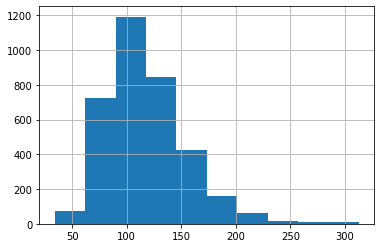

In [14]:
print('max',distr_length.max(),'min', distr_length.min())
display(distr_length.hist())

In [15]:
1 - sum(distr_length>512)/ len(distr_length)

1.0

In [16]:
distr_length.mean(), distr_length.median(), distr_length.std()

(117.66714163579367, 113.0, 36.349050659875225)